In [21]:
import torch
import yaml
from ml_collections import ConfigDict
from argparse import ArgumentParser
import os

from protein_ebm.model.r3_diffuser import R3Diffuser
from protein_ebm.data.protein_utils import residues_to_features, plot_protein_frame, restypes, restype_order, restype_num
from protein_ebm.model.ebm import ProteinEBM
from protein_ebm.model.boltz_utils import center_random_augmentation
import numpy as np



with open("../protein_ebm/config/base_pretrain.yaml", 'r') as f:
    config = yaml.safe_load(f)
    
config = ConfigDict(config)

# Create models
diffuser = R3Diffuser(config.diffuser)
model = ProteinEBM(config.model, diffuser).cuda()


# Load checkpoint
#ckpt = torch.load("../weights/model_1_frozen_1m_md.pt", weights_only=False)
ckpt = torch.load("../weights/model_2_frozen_1m_md.pt", weights_only=False)



model.load_state_dict({k[len("model."):]: v for k, v in ckpt['state_dict'].items() if k.startswith('model')})

<All keys matched successfully>

In [24]:
import os
import pandas as pd

gymdat = pd.read_csv("../eval_data/proteingym/DMS_substitutions.csv")
stab_files = set(gymdat[gymdat['coarse_selection_type'] == 'Stability']['DMS_filename'])


protgym_path = "../eval_data/proteingym/DMS_ProteinGym_substitutions/"

# just use megascale data for this notebook. Delete 'Tsuboyama' filter for all stability datasets
megascale_files = list(reversed([x for x in os.listdir(protgym_path) if x in stab_files and 'Tsuboyama' in x]))
dats = [pd.read_csv(protgym_path + x) for x in megascale_files]
print(len(megascale_files))
print(megascale_files)

64
['POLG_PESV_Tsuboyama_2023_2MXD.csv', 'YNZC_BACSU_Tsuboyama_2023_2JVD.csv', 'MBD11_ARATH_Tsuboyama_2023_6ACV.csv', 'FKBP3_HUMAN_Tsuboyama_2023_2KFV.csv', 'OBSCN_HUMAN_Tsuboyama_2023_1V1C.csv', 'CBX4_HUMAN_Tsuboyama_2023_2K28.csv', 'SOX30_HUMAN_Tsuboyama_2023_7JJK.csv', 'TCRG1_MOUSE_Tsuboyama_2023_1E0L.csv', 'PIN1_HUMAN_Tsuboyama_2023_1I6C.csv', 'SPG2_STRSG_Tsuboyama_2023_5UBS.csv', 'VILI_CHICK_Tsuboyama_2023_1YU5.csv', 'CUE1_YEAST_Tsuboyama_2023_2MYX.csv', 'PITX2_HUMAN_Tsuboyama_2023_2L7M.csv', 'YAIA_ECOLI_Tsuboyama_2023_2KVT.csv', 'PSAE_PICP2_Tsuboyama_2023_1PSE.csv', 'NUSG_MYCTU_Tsuboyama_2023_2MI6.csv', 'RCD1_ARATH_Tsuboyama_2023_5OAO.csv', 'OTU7A_HUMAN_Tsuboyama_2023_2L2D.csv', 'PR40A_HUMAN_Tsuboyama_2023_1UZC.csv', 'ISDH_STAAW_Tsuboyama_2023_2LHR.csv', 'RD23A_HUMAN_Tsuboyama_2023_1IFY.csv', 'RL20_AQUAE_Tsuboyama_2023_1GYZ.csv', 'RPC1_BP434_Tsuboyama_2023_1R69.csv', 'THO1_YEAST_Tsuboyama_2023_2WQG.csv', 'SBI_STAAM_Tsuboyama_2023_2JVG.csv', 'ODP2_GEOSE_Tsuboyama_2023_1W4G.csv', '

In [25]:
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa
from protein_ebm.data.protein_utils import generate_random_backbone_coords

parser = PDBParser(QUIET=True)
input_data_dicts = []
use_unfolded=True

t=0.1
for f in megascale_files:
    pdb_path = "../eval_data/proteingym/ProteinGym_AF2_structures/" + "_".join(f.split("_")[:2]) + ".pdb"

    structure = parser.get_structure("my_structure", pdb_path) 
    chain = list(structure.get_chains())[0]
    atom_positions, atom_mask, aatype, residue_idx = residues_to_features([r for r in chain.get_residues() if is_aa(r)])
    nres = atom_positions.shape[0]

    num_unfolded = 32
    ca_coords = center_random_augmentation(atom_positions[...,1,:].unsqueeze(0), torch.ones([1, nres])).view([1,-1,3])

    
    single_feats = {
        'r_noisy': ca_coords,
        'aatype': aatype.unsqueeze(0),
        'mask': torch.ones([1,nres]),
        'residue_idx': residue_idx.unsqueeze(0),
        't': torch.tensor([t], dtype=torch.float),
        'selfcond_coords' : ca_coords,
    }

    if use_unfolded:
        unfold_feats = []
        seq =  "".join([restypes[a.item()] for a in aatype])
        unfold_feats = []
        unfold_probs = []
        for i in range(num_unfolded):
            unfolded, _ = generate_random_backbone_coords(seq, uniform_sampling=True)
            unfolded = unfolded[..., 1,:] # just the CAs
            unfolded = center_random_augmentation(unfolded.unsqueeze(0), torch.ones([1, nres])).view([1,-1,3])
            unfold_feats.append(unfolded)

        unfolded = torch.cat(unfold_feats)

    if use_unfolded:
        single_feats['r_noisy'] = torch.cat([single_feats['r_noisy'], unfolded])

        for k in single_feats.keys():
            if k != "r_noisy":
                single_feats[k] = torch.cat([single_feats[k]] * (num_unfolded+1))
        
    
    input_data_dicts.append(single_feats)
    

In [26]:
for i in range(len(input_data_dicts)):
    print(input_data_dicts[i]['aatype'].shape)
    print(len(dats[i]['mutated_sequence'][0]))

torch.Size([33, 53])
53
torch.Size([33, 39])
39
torch.Size([33, 66])
66
torch.Size([33, 69])
69
torch.Size([33, 65])
65
torch.Size([33, 50])
50
torch.Size([33, 57])
57
torch.Size([33, 37])
37
torch.Size([33, 39])
39
torch.Size([33, 56])
56
torch.Size([33, 65])
65
torch.Size([33, 52])
52
torch.Size([33, 52])
52
torch.Size([33, 52])
52
torch.Size([33, 68])
68
torch.Size([33, 55])
55
torch.Size([33, 57])
57
torch.Size([33, 42])
42
torch.Size([33, 63])
63
torch.Size([33, 55])
55
torch.Size([33, 44])
44
torch.Size([33, 59])
59
torch.Size([33, 61])
61
torch.Size([33, 41])
41
torch.Size([33, 56])
56
torch.Size([33, 44])
44
torch.Size([33, 69])
69
torch.Size([33, 41])
41
torch.Size([33, 64])
64
torch.Size([33, 40])
40
torch.Size([33, 59])
59
torch.Size([33, 72])
72
torch.Size([33, 52])
52
torch.Size([33, 55])
55
torch.Size([33, 60])
60
torch.Size([33, 71])
71
torch.Size([33, 43])
43
torch.Size([33, 63])
63
torch.Size([33, 56])
56
torch.Size([33, 69])
69
torch.Size([33, 55])
55
torch.Size([33, 

In [ ]:
t = 0.1
nrg_log_all = []
for n in range(len(dats)):

    protgym_data = dats[n]
    single_feats = input_data_dicts[n]
    single_feats = {k:v.cuda() for k,v in single_feats.items()}
    
    nrg_log = []
    with torch.no_grad():        
        native_nrg = model.compute_energy(single_feats)['energy']
        if use_unfolded:
            native_nrg = -native_nrg[0] - torch.logsumexp(-native_nrg[1:], dim=0)
        
        for i,r in protgym_data.iterrows():
            aatype_mut = torch.tensor([restype_order.get(a, restype_num) for a in r['mutated_sequence']])
            mut_feats = {**single_feats, 'aatype' : aatype_mut.unsqueeze(0).cuda().expand([num_unfolded+1, -1]).cuda() if use_unfolded else aatype_mut.unsqueeze(0).cuda()}

            if use_unfolded:
                energy = model.compute_energy(mut_feats)['energy'] 
                energy = -energy[0] - torch.logsumexp(-energy[1:], dim=0) - native_nrg
            else:
                energy = model.compute_energy(mut_feats)['energy']- native_nrg
                
            print(energy)
            nrg_log.append(-energy.item())
    
            aa1 = restype_order.get(r['mutant'][0], restype_num)
            print(megascale_files[n] , i, r['mutant'])
            aa2 = restype_order.get(r['mutant'][-1], restype_num)

        nrg_log_all.append(nrg_log)

tensor(-1.5469, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 0 A1C
tensor(5.3007, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 1 A1D
tensor(-0.4553, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 2 A1E
tensor(-7.2463, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 3 A1F
tensor(3.2548, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 4 A1G
tensor(-2.8619, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 5 A1H
tensor(-2.4338, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 6 A1I
tensor(-6.7876, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 7 A1K
tensor(-5.7739, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 8 A1L
tensor(-6.2726, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 9 A1M
tensor(2.3441, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 10 A1N
tensor(-2.5021, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 11 A1P
tensor(-3.8503, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 12 A1Q
tensor(-6.2612, device='cuda:0')
POLG_PESV_Tsuboyam

In [33]:
len(nrg_log_all)

64

POLG_PESV_Tsuboyama_2023_2MXD.csv
SignificanceResult(statistic=np.float64(-0.7510424959353144), pvalue=np.float64(0.0))


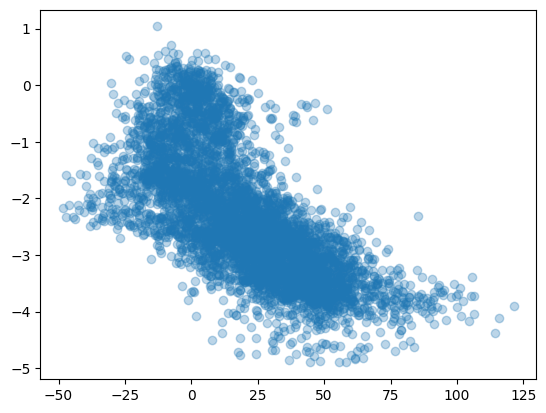

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
i=0
print(megascale_files[i])
plt.scatter(nrg_log_all[i], dats[i]['DMS_score'], alpha=0.3)
print(spearmanr(nrg_log_all[i], dats[i]['DMS_score']))

In [34]:
sprs = []
for i in range(len(megascale_files)):
    sprs.append(spearmanr(nrg_log_all[i], dats[i]['DMS_score'])[0])

print(np.array(sprs).mean())

-0.5407400360489208


In [35]:
sprs

[np.float64(-0.7510424959353144),
 np.float64(-0.6708388083302615),
 np.float64(-0.5948447423496362),
 np.float64(-0.4107355428823831),
 np.float64(-0.8074823193632488),
 np.float64(-0.2199014070815038),
 np.float64(-0.5713694183380512),
 np.float64(-0.7837253836310056),
 np.float64(-0.6194564534057859),
 np.float64(-0.6119016721831204),
 np.float64(-0.5746618092218757),
 np.float64(-0.28619887275505057),
 np.float64(-0.5041587458854866),
 np.float64(-0.305777450259605),
 np.float64(-0.6467809325514897),
 np.float64(-0.6122704830511747),
 np.float64(-0.6165886311942173),
 np.float64(-0.5368720553285401),
 np.float64(-0.6019384622664586),
 np.float64(-0.606710611099625),
 np.float64(-0.6157003034330284),
 np.float64(-0.5769658556072947),
 np.float64(-0.3123931178243808),
 np.float64(-0.4747480954685053),
 np.float64(-0.5389496739968025),
 np.float64(0.004928698647404879),
 np.float64(-0.5752791927765891),
 np.float64(-0.5555928954665984),
 np.float64(-0.5239381993347819),
 np.float64(-0

In [36]:
out_csv_lines = []
for i in range(len(megascale_files)):
    for j,r in dats[i].iterrows():
        out_csv_lines.append(f"{megascale_files[i]},{r['mutant']},{nrg_log_all[i][j]},{r['DMS_score']}\n")

len(out_csv_lines)

117811

In [37]:
with open("../eval_data/model_2_ddgs.csv",'w') as f:
    f.write("name,mutant,model_nrg,dms\n")
    f.writelines(out_csv_lines)